In [9]:
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as T
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt

from experiments.dataset import BGVarDataset, split_dataset
%matplotlib inline

In [20]:
categories = list(BGVarDataset.categories.keys())
times = list(BGVarDataset.times.keys())
weathers = list(BGVarDataset.weathers.keys())
locations = list(BGVarDataset.locations.keys())
bg_var_root = Path("/cmlscratch/pkattaki/datasets/focus")

In [3]:
train_transform = T.Compose(
    [
        T.Resize(224),
        T.RandomCrop(224),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

test_transform = T.Compose(
    [
        T.Resize(224),
        T.CenterCrop(224),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [18]:
def train(model, classifiers, dataloader, optimizers):
    for images, _, time_labels, weather_labels, locations_labels in tqdm(
        dataloader, leave=False
    ):
        images, time_labels, weather_labels, locations_labels = (
            images.cuda(),
            time_labels.cuda(),
            weather_labels.cuda(),
            locations_labels.cuda(),
        )
        locations_labels = locations_labels / torch.sum(
            locations_labels, dim=1, keepdim=True
        )
        attributes = [time_labels, weather_labels, locations_labels]

        _ = model(images)
        for (_, classifier), (_, optimizer), attribute in zip(
            classifiers.items(), optimizers.items(), attributes
        ):
            optimizer.zero_grad()
            outputs = classifier(features["features"].squeeze())
            loss = F.cross_entropy(outputs, attribute)
            loss.backward()
            optimizer.step()


def test(model, classifiers, dataloader):

    num_corrects = {
        "time": 0,
        "weather": 0,
        "location": 0,
    }
    confusion_matrices = {
        "time": np.zeros((3, 3)),
        "weather": np.zeros((7, 7)),
    }
    total = 0.0
    avg_loss = 0
    with torch.no_grad():
        for images, _, time_labels, weather_labels, locations_labels in dataloader:
            images, time_labels, weather_labels, locations_labels = (
                images.cuda(),
                time_labels.cuda(),
                weather_labels.cuda(),
                locations_labels.cuda(),
            )
            locations_labels = locations_labels / torch.sum(
                locations_labels, dim=1, keepdim=True
            )
            attributes = [time_labels, weather_labels, locations_labels]

            _ = model(images)
            total += images.shape[0]
            for (classifier_key, classifier), attribute, attribute_name in zip(
                classifiers.items(), attributes, num_corrects.keys()
            ):
                try:
                    assert classifier_key == attribute_name
                except AssertionError as e:
                    print(classifier_key, attribute_name)
                    raise e
                outputs = classifier(features["features"].squeeze())
                loss = F.cross_entropy(outputs, attribute)
                _, predicted = torch.max(outputs, dim=1)
                if attribute_name != "location":
                    num_corrects[attribute_name] += (predicted == attribute).sum().item()
                    for i in range(images.shape[0]):
                        confusion_matrices[attribute_name][attribute[i]][predicted[i]] += 1
                else:
                    avg_loss += loss
        for attribute in num_corrects:
            num_corrects[attribute] /= total
    return num_corrects, avg_loss.cpu().item() / len(dataloader.dataset), confusion_matrices

In [5]:
locations_dataset = BGVarDataset(
    bg_var_root,
    categories=categories,
    times=None,
    weathers=None,
    locations=None,
    transform=train_transform,
)
print(len(locations_dataset))

train_set, test_set = split_dataset(locations_dataset, train_fraction=0.85)

features = {}


def hook(model, input, output):
    features["features"] = output


model = models.resnet50(pretrained=True)
for parameter in model.parameters():
    parameter.requires_grad_(False)

attribute_classifiers = {
    "time": nn.Linear(2048, 3),
    "weather": nn.Linear(2048, 7),
    "location": nn.Linear(2048, 9),
}

for _, classifier in attribute_classifiers.items():
    classifier.cuda()

model.eval()
model.cuda()
model.avgpool.register_forward_hook(hook)

20815


In [6]:
train_loader = DataLoader(
    train_set, batch_size=32, num_workers=4, pin_memory=True, shuffle=True
)
test_loader = DataLoader(
    test_set, batch_size=32, num_workers=4, pin_memory=True, shuffle=False
)

num_epochs = 50
optimizers = {
    k: torch.optim.Adam(v.parameters()) for k, v in attribute_classifiers.items()
}
test_accuracies = np.zeros(num_epochs)

/cmlscratch/pkattaki/developer/pytorch/lib/python3.8/site-packages/torch/utils/data/dataloader.py:478: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
for epoch in range(num_epochs):
    train(model, attribute_classifiers, train_loader, optimizers)

ckpt = {k: v.state_dict() for k, v in attribute_classifiers.items()}
torch.save(ckpt, "attribute_classifiers.pth")

In [7]:
ckpt = torch.load("./attribute_classifiers.pth")
for k, v in attribute_classifiers.items():
    v.load_state_dict(ckpt[k])

In [19]:
num_corrects, location_loss, confusion_matrices = test(model, attribute_classifiers, test_loader)
print(f"Test loss: {num_corrects, location_loss}")
print(confusion_matrices)

Test loss: ({'time': 0.8722382324687801, 'weather': 0.6000640409862312, 'location': 0.0}, 0.036328443074661536)
{'time': array([[2459.,   36.,  124.],
       [  44.,  108.,   19.],
       [ 147.,   29.,  157.]]), 'weather': array([[ 71.,  33.,  11.,   0.,   0.,  56.,  72.],
       [ 11.,  37.,   1.,   0.,   1.,   9.,  25.],
       [ 39.,   5.,  26.,   0.,   0., 144.,  91.],
       [  0.,   4.,   0.,   4.,   1.,   3.,  15.],
       [  4.,   5.,   0.,   1.,   8.,   2.,  11.],
       [ 40.,  13.,  25.,   0.,   1., 829., 333.],
       [ 28.,  17.,   8.,   4.,   4., 232., 899.]])}


In [38]:
inv_transform = T.Compose(
    [
        T.Normalize(mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225], std=[1 / 0.229, 1 / 0.224, 1 / 0.225]),
        T.ToPILImage(),
    ]
)
def find_inaccuracies(model, classifiers, dataloader):

    num_corrects = {
        "time": 0,
        "weather": 0,
    }

    total = 0.0
    avg_loss = 0
    
    num_incorrects = 5
    _, ax = plt.subplots(2 * num_incorrects, 1, figsize=(5, 50))
    idx = 1
    
    with torch.no_grad():
        for images, _, time_labels, weather_labels, locations_labels in dataloader:
            if idx > 2 * num_incorrects:
                break
            images, time_labels, weather_labels = (
                images.cuda(),
                time_labels.cuda(),
                weather_labels.cuda(),
            )
            attributes = [time_labels, weather_labels]

            _ = model(images)
            
            for (classifier_key, classifier), attribute, attribute_name in zip(
                classifiers.items(), attributes, num_corrects.keys()
            ):
                assert classifier_key == attribute_name
                if (classifier_key == "time" and idx <= num_incorrects) or (classifier_key == "weather" and idx > num_incorrects):
                    outputs = classifier(features["features"].squeeze())
                    _, predicted = torch.max(outputs, dim=1)
                    for i in range(images.shape[0]):
                        if idx > 2 * num_incorrects:
                            break
                        if predicted[i] != attribute[i]:
                            ax[idx - 1].imshow(inv_transform(images[i]))
                            if idx <= num_incorrects:
                                ax[idx - 1].set_title(f"time-{times[time_labels[i]]}-{times[predicted[i]]}")
                            else:
                                ax[idx - 1].set_title(f"weather-{weathers[weather_labels[i]]}-{weathers[predicted[i]]}")
                            idx += 1


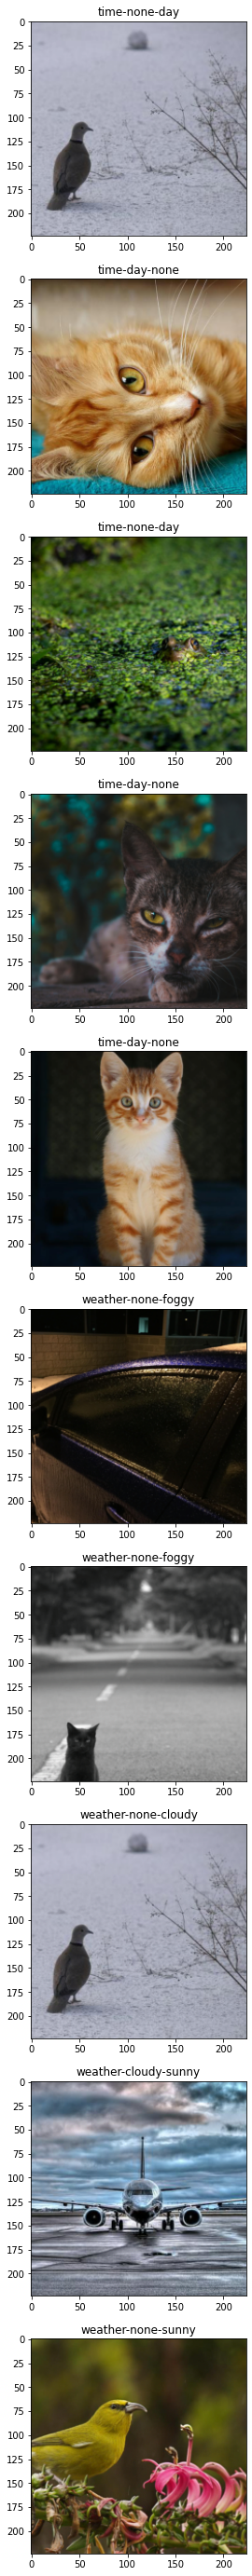

In [39]:
find_inaccuracies(model, attribute_classifiers, test_loader)

In [40]:
num_corrects, location_loss, confusion_matrices = test(model, attribute_classifiers, train_loader)
print(f"Test loss: {num_corrects, location_loss}")
print(confusion_matrices)

Test loss: ({'time': 0.9203029617906399, 'weather': 0.689690255482704, 'location': 0.0}, 0.02679145290332495)
{'time': array([[14332.,    84.,   368.],
       [  128.,   692.,    51.],
       [  718.,    61.,  1258.]]), 'weather': array([[6.780e+02, 1.060e+02, 3.900e+01, 0.000e+00, 0.000e+00, 2.710e+02,
        3.560e+02],
       [2.500e+01, 3.730e+02, 2.000e+00, 0.000e+00, 0.000e+00, 2.700e+01,
        6.400e+01],
       [1.870e+02, 5.100e+01, 2.940e+02, 0.000e+00, 0.000e+00, 6.720e+02,
        4.950e+02],
       [5.000e+00, 1.400e+01, 0.000e+00, 7.600e+01, 0.000e+00, 8.000e+00,
        5.200e+01],
       [8.000e+00, 1.300e+01, 0.000e+00, 2.000e+00, 1.090e+02, 1.200e+01,
        5.400e+01],
       [1.520e+02, 8.000e+01, 6.600e+01, 1.000e+00, 0.000e+00, 4.885e+03,
        1.478e+03],
       [1.480e+02, 9.200e+01, 2.600e+01, 2.000e+00, 4.000e+00, 9.780e+02,
        5.787e+03]])}
